<div style="background-color:#e0f7fa; padding:20px; border-left:6px solid teal; border-radius:12px; text-align:center;">
  <h2 style="color:teal; font-weight:bold; font-family:Arial, sans-serif; margin:0;">
     <span style="font-size:28px;">Student Performace</span>
  </h2>
</div>


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
import graphviz
import seaborn as sns
from sklearn.metrics import accuracy_score
from IPython.display import display

# P1: ĐỌC DỮ LIỆU VÀ XỬ LÝ 

## 1. Đọc dữ liệu  

In [2]:
student = pd.read_csv("StudentsPerformance.csv")

print(student.info())

print(student.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None
   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      s

## 2. In dữ liệu để kiểm tra   

In [3]:
for col in student.columns:
  print(f"Cột: {col}")
  print(student[col].unique())

Cột: gender
['female' 'male']
Cột: race/ethnicity
['group B' 'group C' 'group A' 'group D' 'group E']
Cột: parental level of education
["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Cột: lunch
['standard' 'free/reduced']
Cột: test preparation course
['none' 'completed']
Cột: math score
[ 72  69  90  47  76  71  88  40  64  38  58  65  78  50  18  46  54  66
  44  74  73  67  70  62  63  56  97  81  75  57  55  53  59  82  77  33
  52   0  79  39  45  60  61  41  49  30  80  42  27  43  68  85  98  87
  51  99  84  91  83  89  22 100  96  94  48  35  34  86  92  37  28  24
  26  95  36  29  32  93  19  23   8]
Cột: reading score
[ 72  90  95  57  78  83  43  64  60  54  52  81  53  75  89  32  42  58
  69  73  71  74  70  65  87  56  61  84  55  44  41  85  59  17  39  80
  37  63  51  49  26  68  45  47  86  34  79  66  67  91 100  76  77  82
  92  93  62  88  50  28  48  46  23  38  94  97  99  31  96  24  29  40]
Cột: wri

## 3. Kiểm tra dữ liệu null  

In [4]:
print("Kiểm tra dữ liệu bị thiếu (null values):")
print(student.isnull().sum())

Kiểm tra dữ liệu bị thiếu (null values):
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


## 4. Kiểm tra outlier  

In [5]:
outlier_summary = {}

for col in ['math score', 'reading score', 'writing score']:
    Q1 =student[col].quantile(0.25)
    Q3 =student[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = student[(student[col] < lower_bound) | (student[col] > upper_bound)]
    outlier_count = len(outliers)

    outlier_summary[col] = {
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Outlier Count": outlier_count
    }

# Hiển thị kết quả
print("Thống kê outlier theo IQR:")
for col, stats in outlier_summary.items():
    print(f"\n  {col}")
    for key, val in stats.items():
        print(f"  {key}: {val}")


Thống kê outlier theo IQR:

  math score
  Q1: 57.0
  Q3: 77.0
  IQR: 20.0
  Lower Bound: 27.0
  Upper Bound: 107.0
  Outlier Count: 8

  reading score
  Q1: 59.0
  Q3: 79.0
  IQR: 20.0
  Lower Bound: 29.0
  Upper Bound: 109.0
  Outlier Count: 6

  writing score
  Q1: 57.75
  Q3: 79.0
  IQR: 21.25
  Lower Bound: 25.875
  Upper Bound: 110.875
  Outlier Count: 5


### => Mặc dù phát hiện ra outlier nhưng do số lượng ít và hợp lý về mặt học tập nên dữ liệu được giữ nguyên   

## 7. One-hot coding các features  

In [6]:
student['average_score'] = student[['math score', 'reading score', 'writing score']].mean(axis=1)

# 2. Tạo nhãn 3 lớp
def map_grade(avg):
    if avg < 60:
        return 0  # Yếu
    elif avg < 80:
        return 1  # TB – Khá
    else:
        return 2  # Giỏi

student['target'] = student['average_score'].apply(map_grade)


student.drop(columns=['average_score'], inplace=True)


print("Phân bố nhãn (multi-class):")
print(student['target'].value_counts().sort_index())


Phân bố nhãn (multi-class):
target
0    285
1    517
2    198
Name: count, dtype: int64


# P2: Chia tập train/test trên 4 tý lệ  

## 1. Tách dữ liệu thành đặc trưng và nhãn  

In [7]:
X = pd.get_dummies(student.drop(columns=['target']), drop_first=True)
y = student['target']

## 2. Tạo các tập train/test  

In [8]:
ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
datasets = {} 

## 3. THực hiện chia train/test  

### 3.1 Chia tập train/test  

In [9]:
for train_size, test_size in ratios:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)

    for train_idx, test_idx in sss.split(X, y):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]

        key = f"{int(train_size*100)}_{int(test_size*100)}"
        datasets[key] = {
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test
        }

        print(f"Tập chia: {key}")
        print("  • Số mẫu train:", X_train.shape[0])
        print("  • Số mẫu test :", X_test.shape[0])
        print("-" * 50)

Tập chia: 40_60
  • Số mẫu train: 400
  • Số mẫu test : 600
--------------------------------------------------
Tập chia: 60_40
  • Số mẫu train: 600
  • Số mẫu test : 400
--------------------------------------------------
Tập chia: 80_20
  • Số mẫu train: 800
  • Số mẫu test : 200
--------------------------------------------------
Tập chia: 90_10
  • Số mẫu train: 900
  • Số mẫu test : 100
--------------------------------------------------


### 3.2 Visulize để thể hiện phân bố  

#### a. Tỉ lệ trên tập gốc  

C:\Users\Dell\AppData\Local\Temp\ipykernel_33796\67915229.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=label_counts.index.astype(str), y=label_props.values, palette=colors)


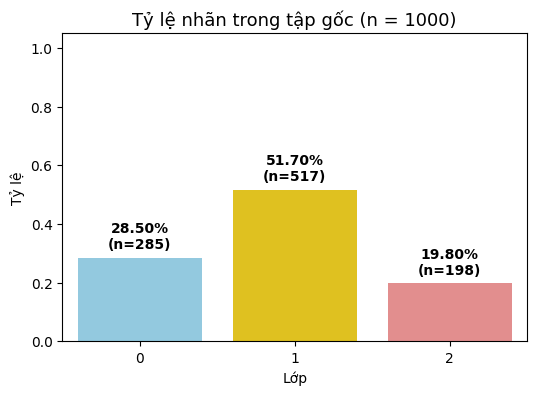

In [10]:
label_counts = y.value_counts().sort_index()
label_props = y.value_counts(normalize=True).sort_index().round(4)
total = len(y)

plt.figure(figsize=(6, 4))
colors = ["skyblue", "gold", "lightcoral"]  # 3 lớp

bars = sns.barplot(x=label_counts.index.astype(str), y=label_props.values, palette=colors)

for i, (count, prop) in enumerate(zip(label_counts, label_props)):
    bars.text(i, prop + 0.02,
              f"{(prop*100):.2f}%\n(n={count})",
              ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.ylim(0, 1.05)
plt.ylabel("Tỷ lệ")
plt.title(f"Tỷ lệ nhãn trong tập gốc (n = {total})", fontsize=13)
plt.xlabel("Lớp")
plt.show()


#### b. Trên từng tập train/test  

C:\Users\Dell\AppData\Local\Temp\ipykernel_33796\3520816060.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index.astype(str), y=train_props.values,
C:\Users\Dell\AppData\Local\Temp\ipykernel_33796\3520816060.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_counts.index.astype(str), y=test_props.values,


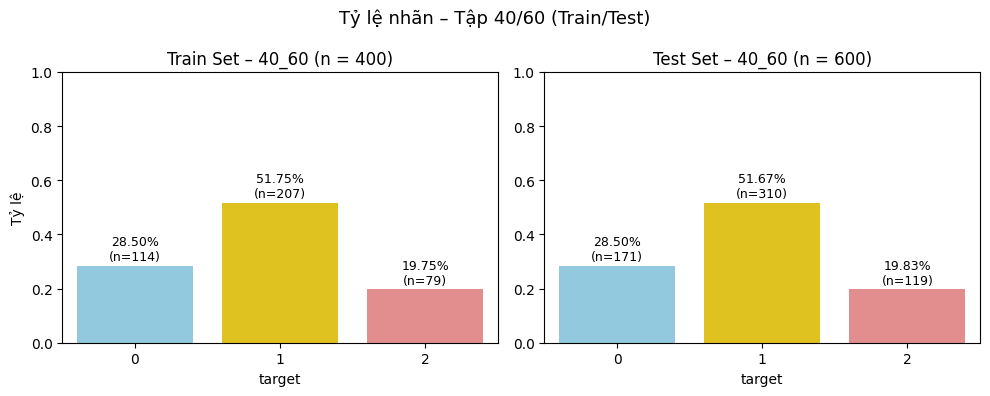

C:\Users\Dell\AppData\Local\Temp\ipykernel_33796\3520816060.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index.astype(str), y=train_props.values,
C:\Users\Dell\AppData\Local\Temp\ipykernel_33796\3520816060.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_counts.index.astype(str), y=test_props.values,


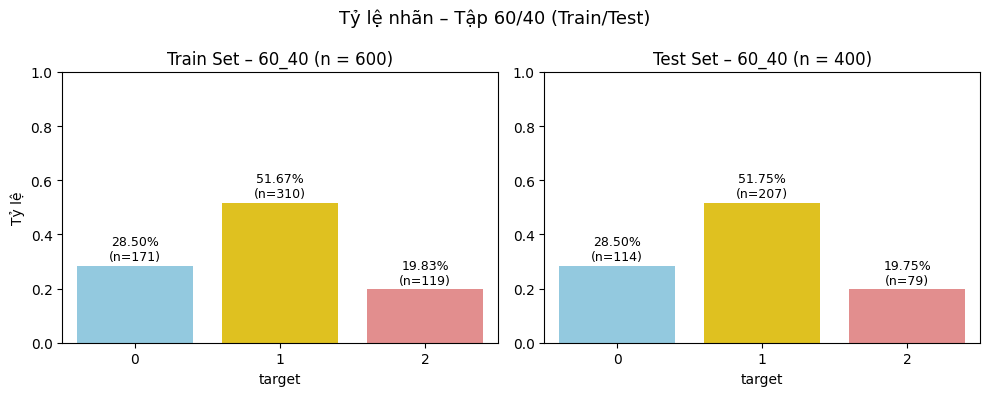

C:\Users\Dell\AppData\Local\Temp\ipykernel_33796\3520816060.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index.astype(str), y=train_props.values,
C:\Users\Dell\AppData\Local\Temp\ipykernel_33796\3520816060.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_counts.index.astype(str), y=test_props.values,


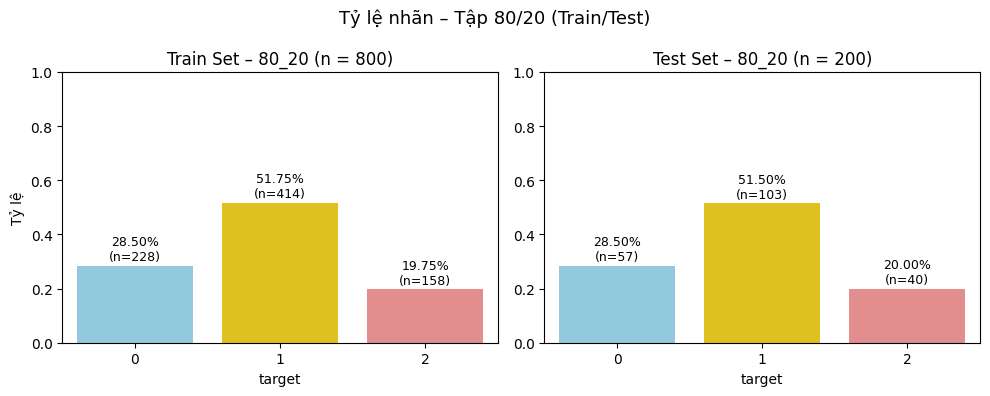

C:\Users\Dell\AppData\Local\Temp\ipykernel_33796\3520816060.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index.astype(str), y=train_props.values,
C:\Users\Dell\AppData\Local\Temp\ipykernel_33796\3520816060.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_counts.index.astype(str), y=test_props.values,


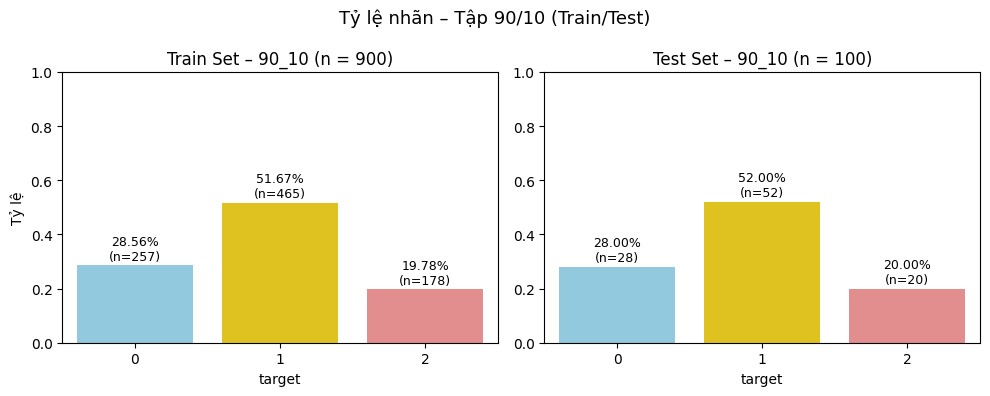

In [11]:
for key, subset in datasets.items():
    y_train = subset['y_train']
    y_test = subset['y_test']

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    colors = ["skyblue", "gold", "lightcoral"]

    # ---------- TRAIN ----------
    train_counts = y_train.value_counts().sort_index()
    train_props = y_train.value_counts(normalize=True).sort_index()
    n_train = len(y_train)

    sns.barplot(x=train_counts.index.astype(str), y=train_props.values,
                palette=colors, ax=axs[0])
    axs[0].set_title(f"Train Set – {key} (n = {n_train})")
    axs[0].set_ylim(0, 1)
    axs[0].set_ylabel("Tỷ lệ")

    for i, (count, prop) in enumerate(zip(train_counts, train_props)):
        axs[0].text(i, prop + 0.02,
                    f"{prop:.2%}\n(n={count})",
                    ha='center', fontsize=9)

    # ---------- TEST ----------
    test_counts = y_test.value_counts().sort_index()
    test_props = y_test.value_counts(normalize=True).sort_index()
    n_test = len(y_test)

    sns.barplot(x=test_counts.index.astype(str), y=test_props.values,
                palette=colors, ax=axs[1])
    axs[1].set_title(f"Test Set – {key} (n = {n_test})")
    axs[1].set_ylim(0, 1)
    axs[1].set_ylabel("")

    for i, (count, prop) in enumerate(zip(test_counts, test_props)):
        axs[1].text(i, prop + 0.02,
                    f"{prop:.2%}\n(n={count})",
                    ha='center', fontsize=9)

    plt.suptitle(f"Tỷ lệ nhãn – Tập {key.replace('_', '/')} (Train/Test)", fontsize=13)
    plt.tight_layout()
    plt.show()


# P3: Huấn luyện cây quyết định  

## 1. Build cây quyết định  


Cây quyết định – Tập 40/60 (max_depth = 4)


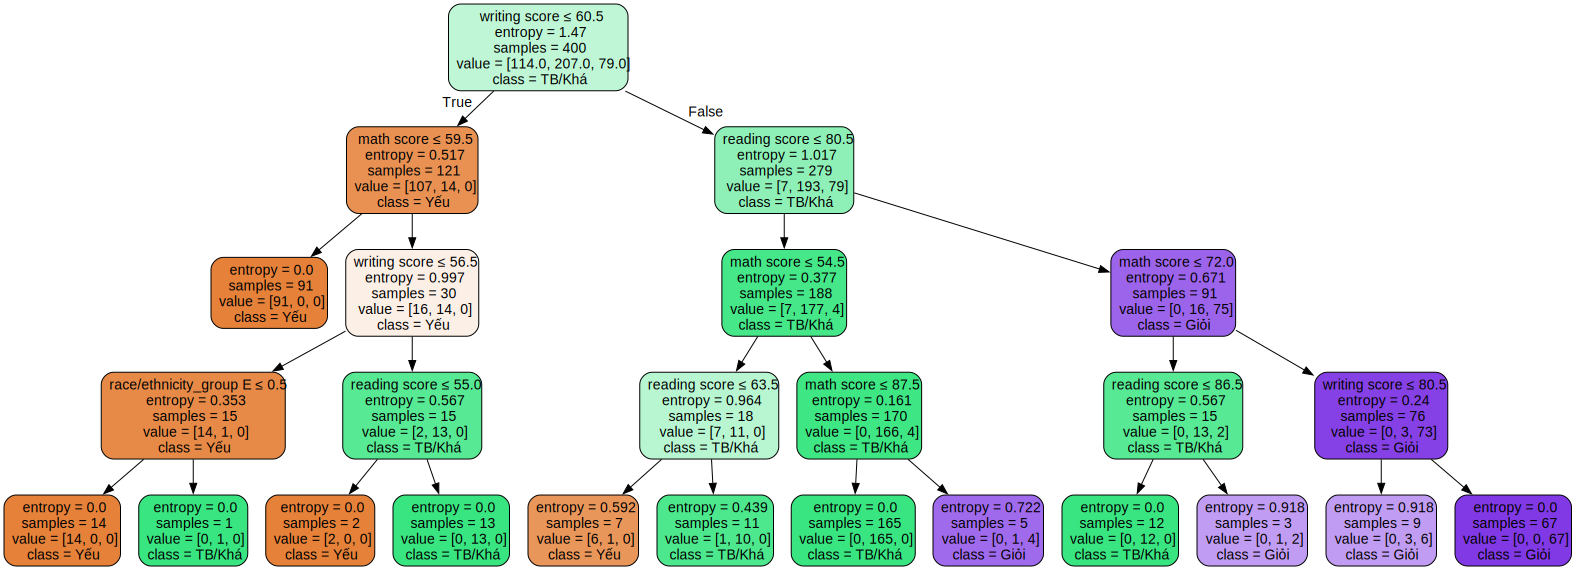


Cây quyết định – Tập 60/40 (max_depth = 4)


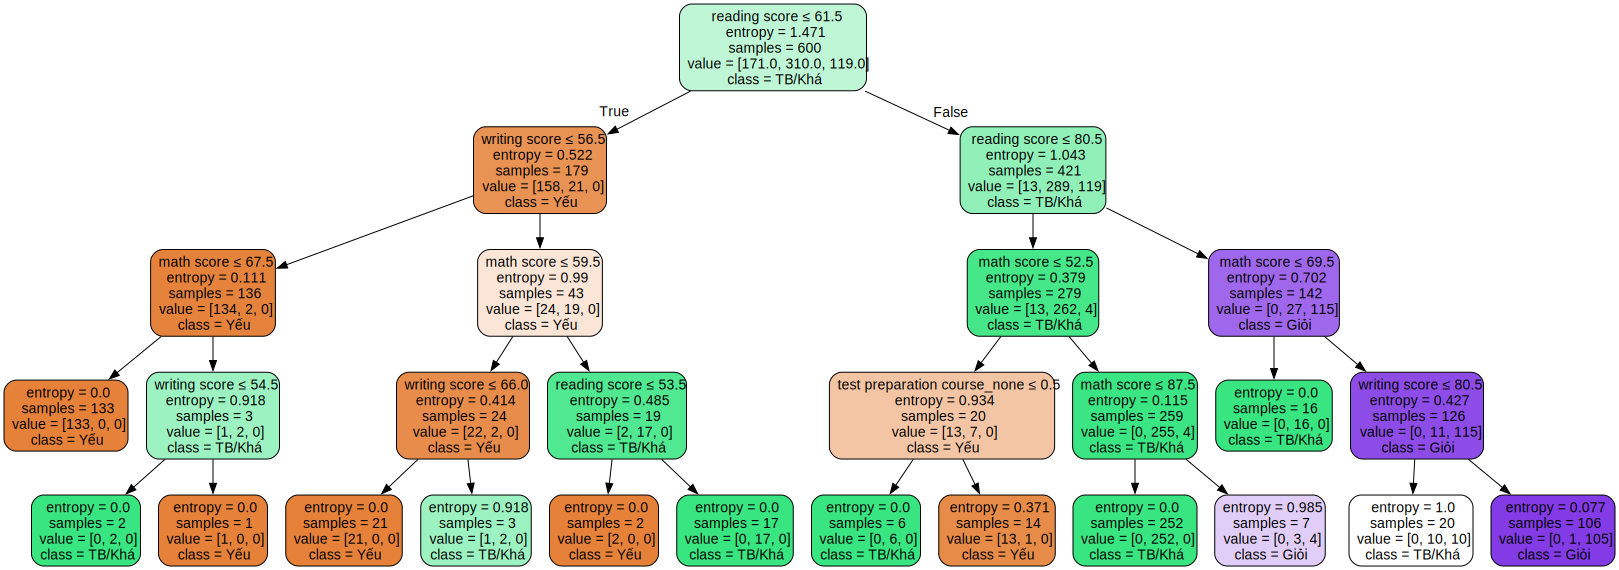


Cây quyết định – Tập 80/20 (max_depth = 4)


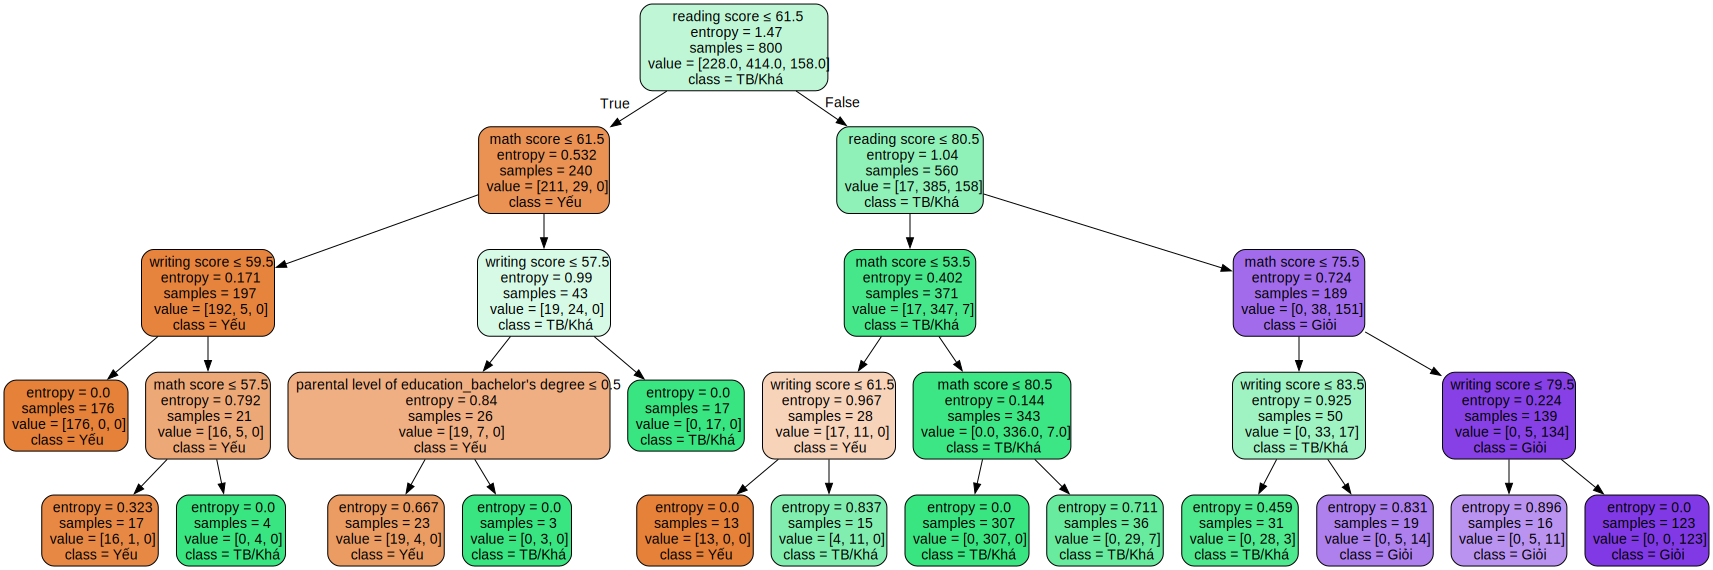


Cây quyết định – Tập 90/10 (max_depth = 4)


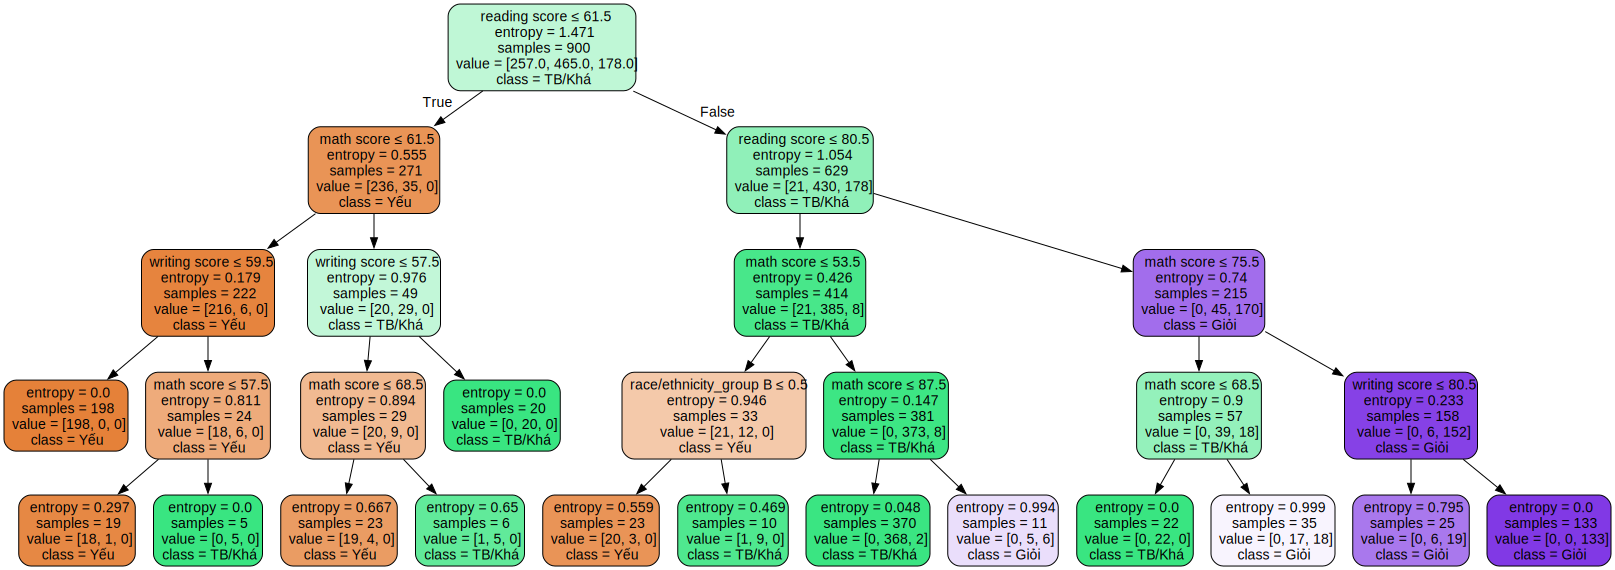

In [12]:
models = {}

for key, subset in datasets.items():
    X_train = subset['X_train']
    y_train = subset['y_train']

    clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
    clf.fit(X_train, y_train)
    models[key] = clf

    dot_data = export_graphviz(clf,
                                out_file=None,
                                feature_names=X_train.columns,
                                class_names=["Yếu", "TB/Khá", "Giỏi"],
                                filled=True, rounded=True,
                                special_characters=True)

    graph = graphviz.Source(dot_data)

    print(f"\nCây quyết định – Tập {key.replace('_', '/')} (max_depth = 4)")
    display(graph)

## 2. Đánh giá mô hình và confusion matrix  


Accuracy in test set : 0.9333

ĐÁNH GIÁ – Tập 40/60 (max_depth = 4)

Classification Report:
              precision    recall  f1-score   support

         Yếu     0.9521    0.9298    0.9408       171
      TB/Khá     0.9470    0.9226    0.9346       310
        Giỏi     0.8779    0.9664    0.9200       119

    accuracy                         0.9333       600
   macro avg     0.9257    0.9396    0.9318       600
weighted avg     0.9348    0.9333    0.9335       600



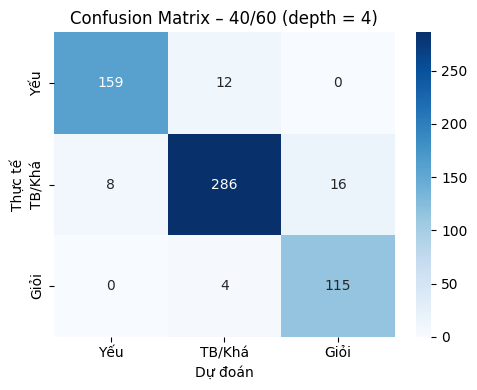


Accuracy in test set : 0.9025

ĐÁNH GIÁ – Tập 60/40 (max_depth = 4)

Classification Report:
              precision    recall  f1-score   support

         Yếu     0.9450    0.9035    0.9238       114
      TB/Khá     0.8750    0.9469    0.9095       207
        Giỏi     0.9254    0.7848    0.8493        79

    accuracy                         0.9025       400
   macro avg     0.9151    0.8784    0.8942       400
weighted avg     0.9049    0.9025    0.9017       400



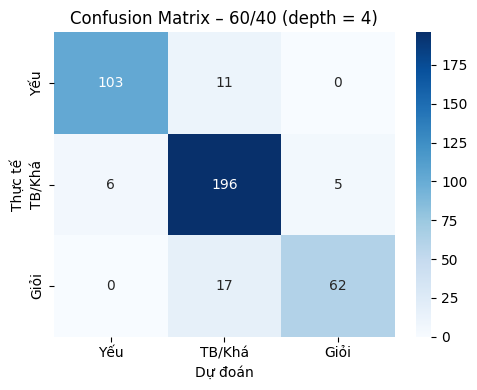


Accuracy in test set : 0.9350

ĐÁNH GIÁ – Tập 80/20 (max_depth = 4)

Classification Report:
              precision    recall  f1-score   support

         Yếu     0.9636    0.9298    0.9464        57
      TB/Khá     0.9245    0.9515    0.9378       103
        Giỏi     0.9231    0.9000    0.9114        40

    accuracy                         0.9350       200
   macro avg     0.9371    0.9271    0.9319       200
weighted avg     0.9354    0.9350    0.9350       200



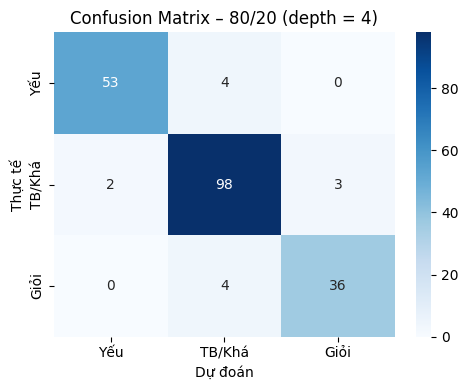


Accuracy in test set : 0.9200

ĐÁNH GIÁ – Tập 90/10 (max_depth = 4)

Classification Report:
              precision    recall  f1-score   support

         Yếu     0.9259    0.8929    0.9091        28
      TB/Khá     0.9231    0.9231    0.9231        52
        Giỏi     0.9048    0.9500    0.9268        20

    accuracy                         0.9200       100
   macro avg     0.9179    0.9220    0.9197       100
weighted avg     0.9202    0.9200    0.9199       100



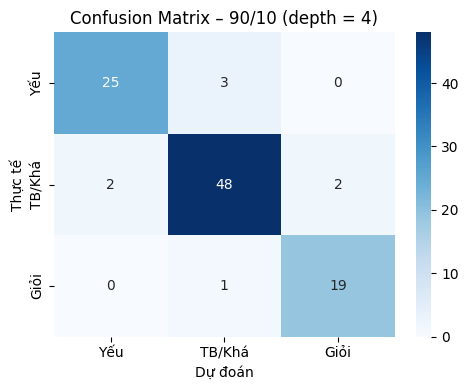

In [17]:
for key, clf in models.items():
    X_test = datasets[key]['X_test']
    y_test = datasets[key]['y_test']
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)  
    print(f"\nAccuracy in test set : {acc:.4f}")  
    # Lấy độ sâu thực tế của cây
    depth = clf.get_depth()

    print(f"\nĐÁNH GIÁ – Tập {key.replace('_', '/')} (max_depth = {depth})")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4, target_names=["Yếu", "TB/Khá", "Giỏi"]))

    # Vẽ confusion matrix có in độ sâu
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Yếu", "TB/Khá", "Giỏi"],
                yticklabels=["Yếu", "TB/Khá", "Giỏi"])
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.title(f"Confusion Matrix – {key.replace('_', '/')} (depth = {depth})")
    plt.tight_layout()
    plt.show()


# P4. So sánh theo max_depth  

## 1. Huấn luyện mô hình với max_depth  

In [14]:
X_train = datasets['80_20']['X_train']
y_train = datasets['80_20']['y_train']
X_test = datasets['80_20']['X_test']
y_test = datasets['80_20']['y_test']

depth_list = [None, 2, 3, 4, 5, 6, 7]
models_by_depth = {}
accuracy_results = []

for depth in depth_list:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    models_by_depth[depth] = clf

    y_pred = clf.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 4)
    accuracy_results.append((depth, acc))

    print(f"Huấn luyện xong: depth={depth}, accuracy={acc}")


Huấn luyện xong: depth=None, accuracy=0.94
Huấn luyện xong: depth=2, accuracy=0.875
Huấn luyện xong: depth=3, accuracy=0.93
Huấn luyện xong: depth=4, accuracy=0.935
Huấn luyện xong: depth=5, accuracy=0.955
Huấn luyện xong: depth=6, accuracy=0.935
Huấn luyện xong: depth=7, accuracy=0.94


## 2. Bulid decision tree   


Cây quyết định (max_depth = None)


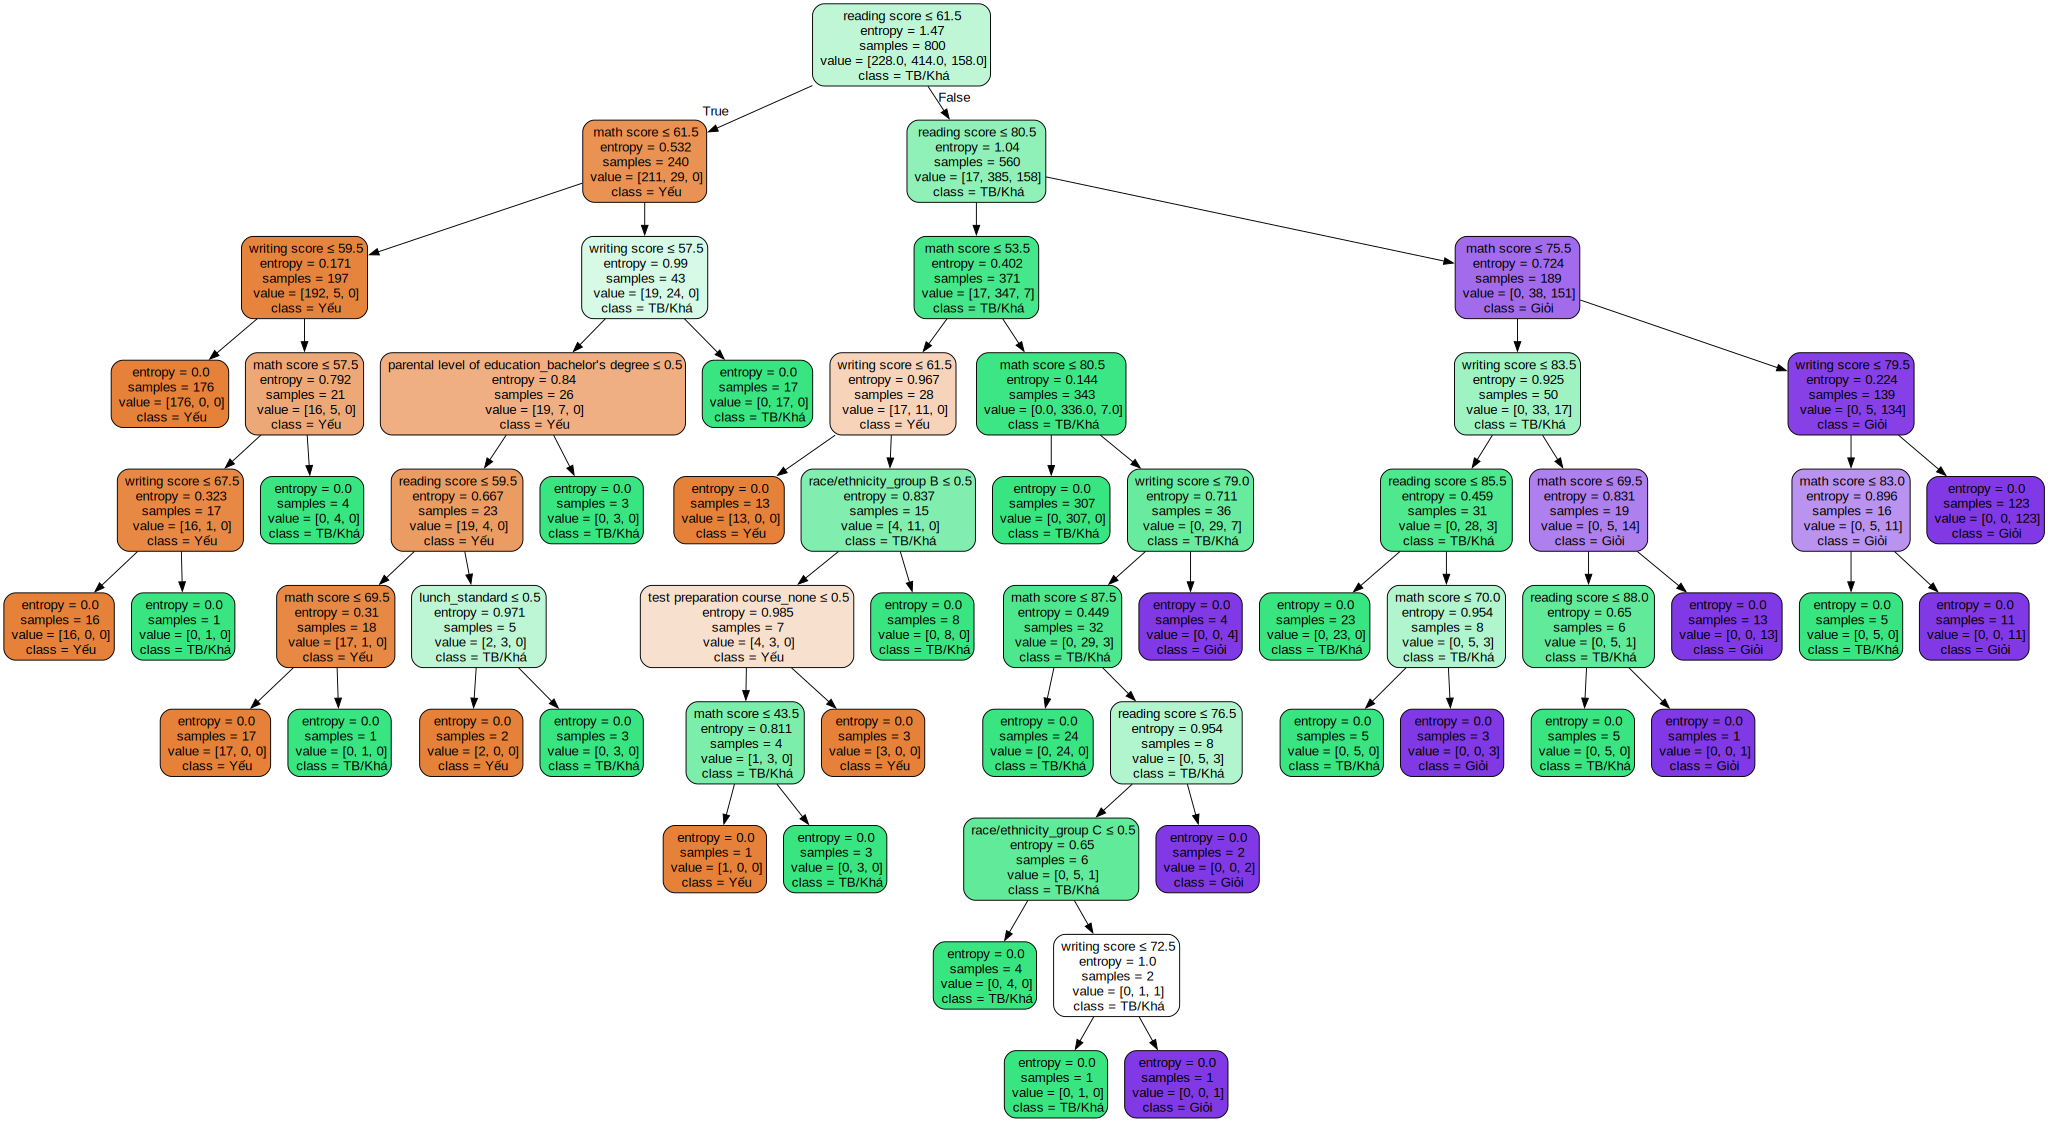


Cây quyết định (max_depth = 2)


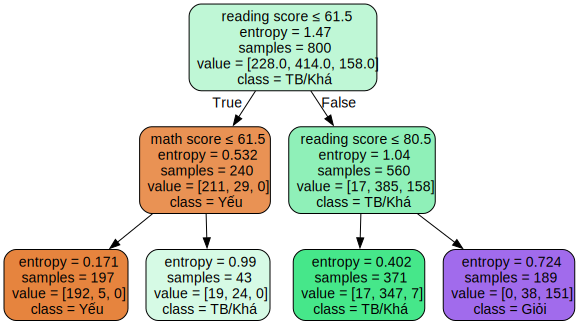


Cây quyết định (max_depth = 3)


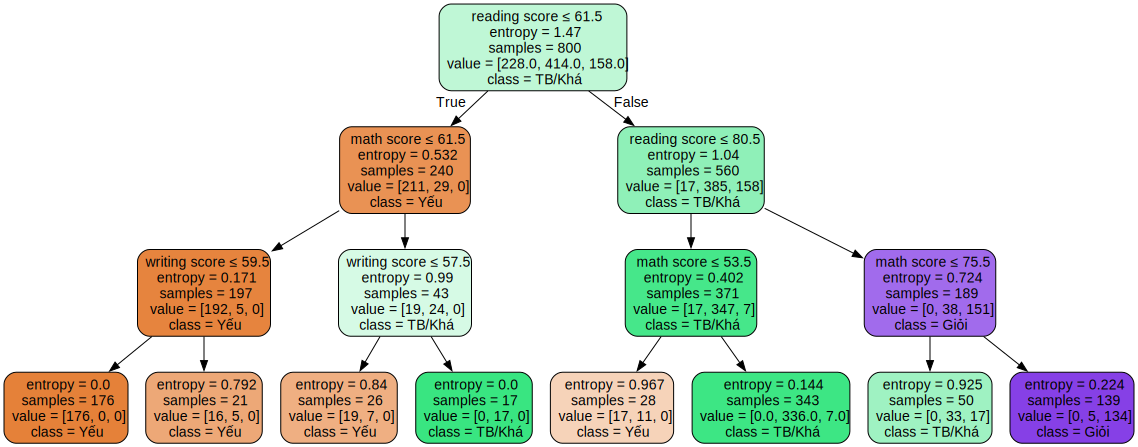


Cây quyết định (max_depth = 4)


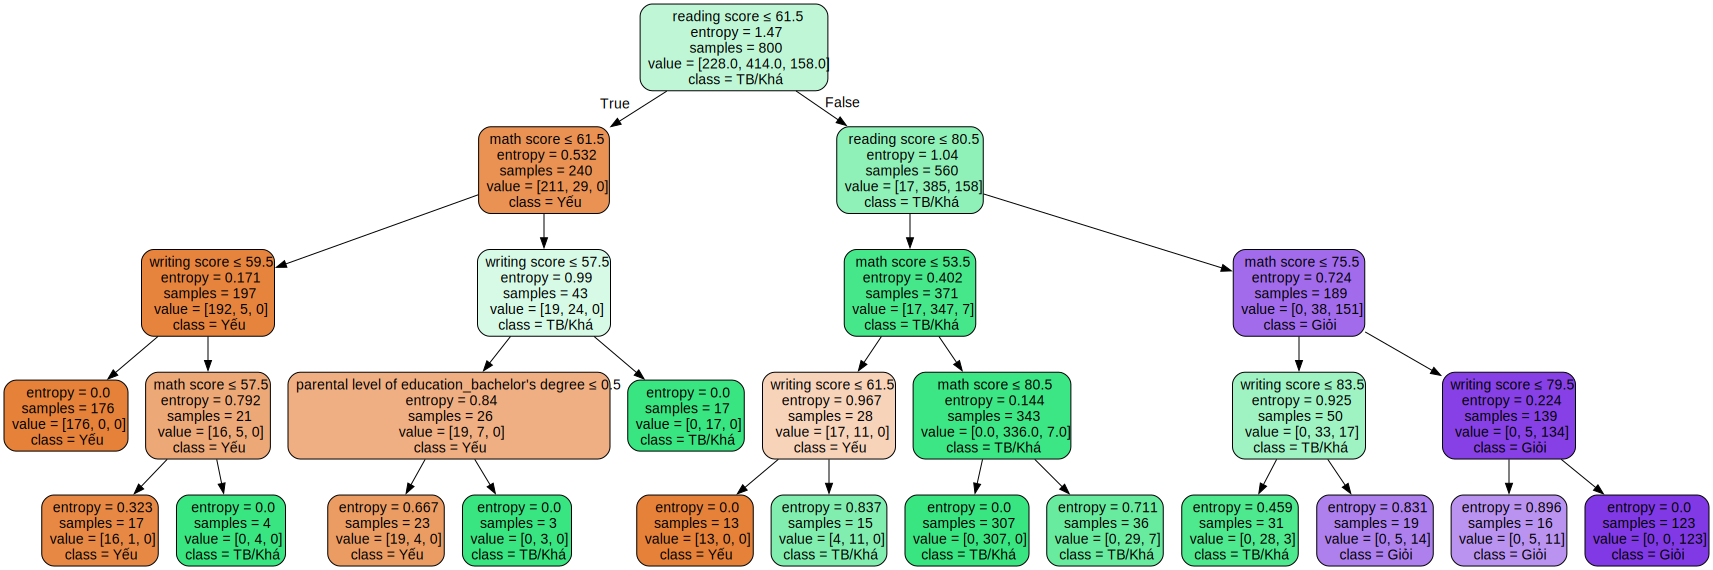


Cây quyết định (max_depth = 5)


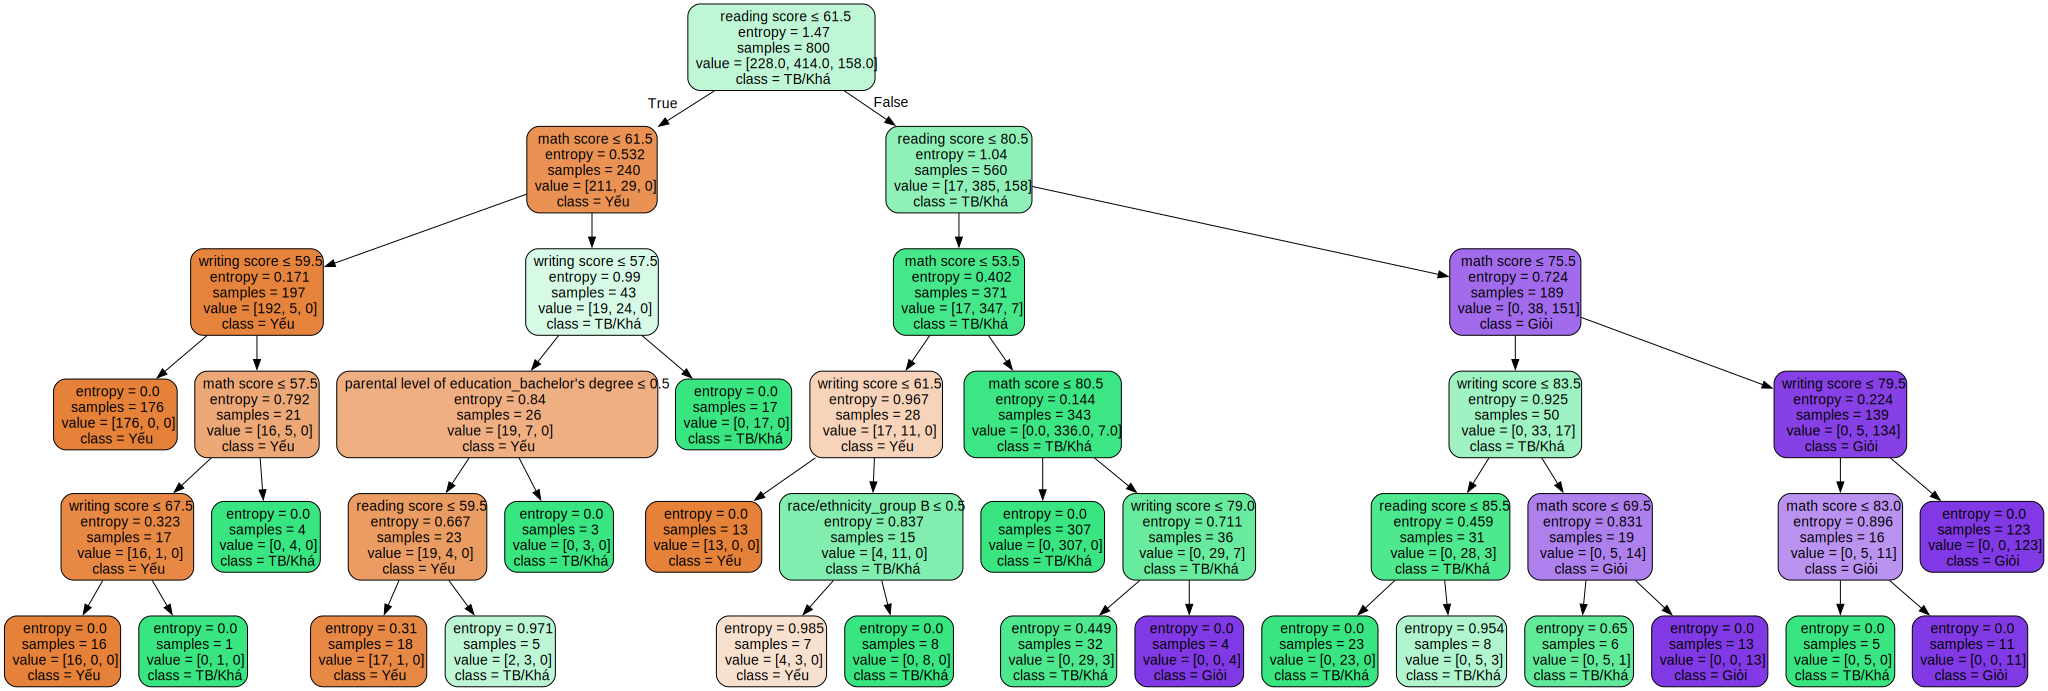


Cây quyết định (max_depth = 6)


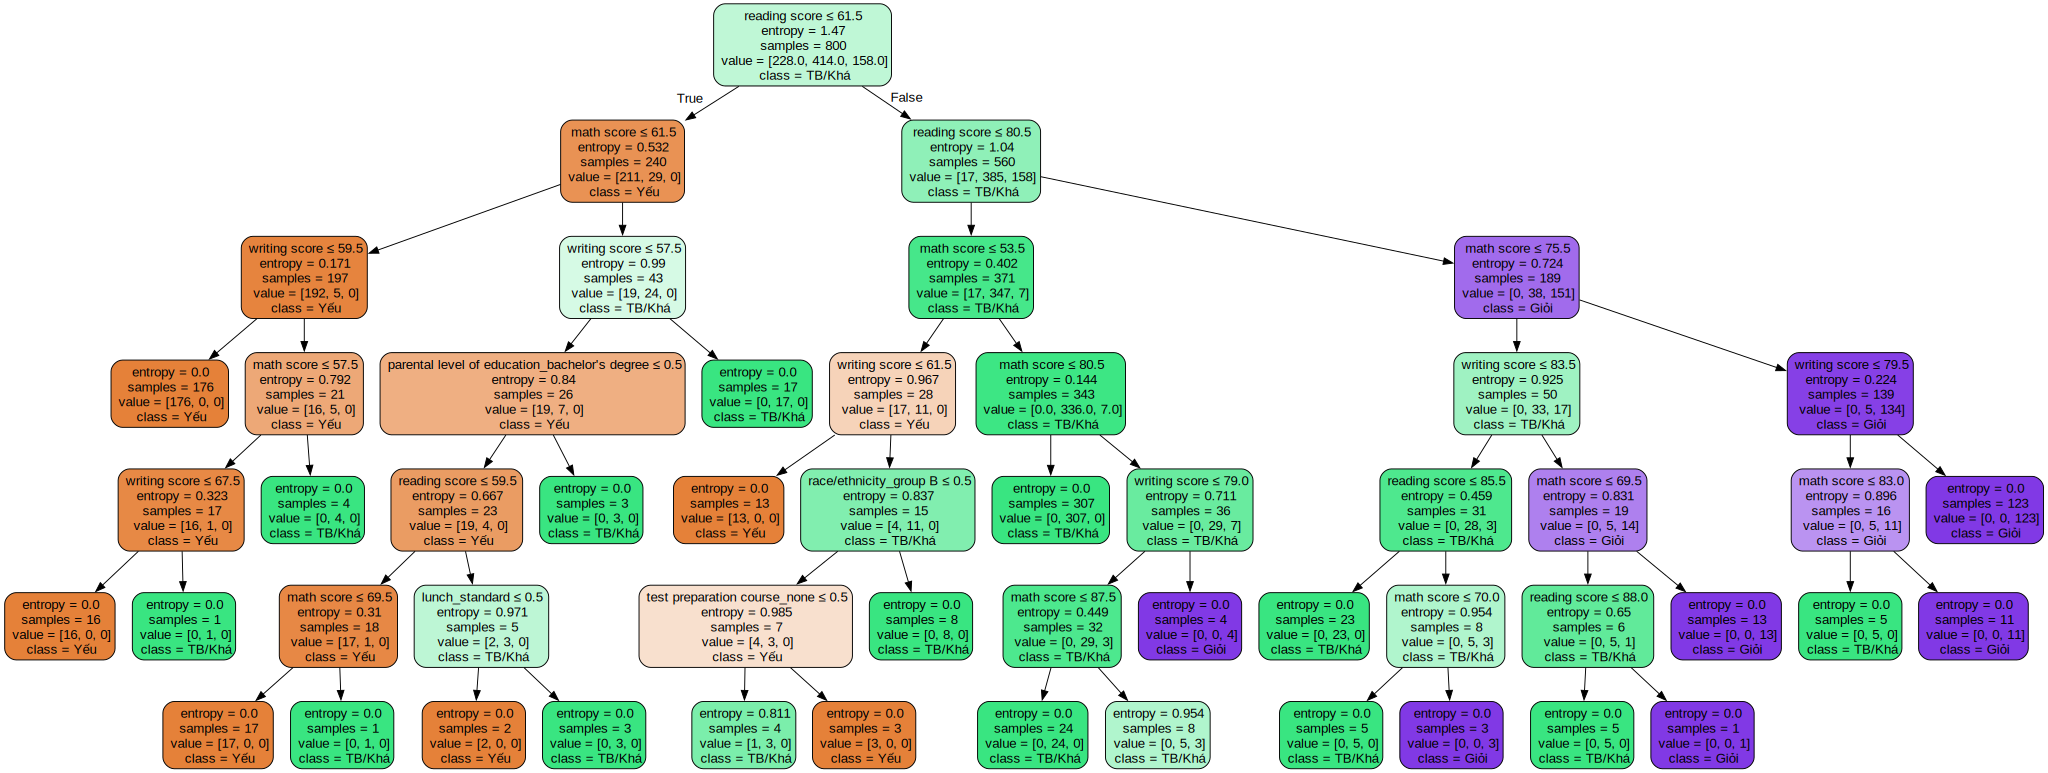


Cây quyết định (max_depth = 7)


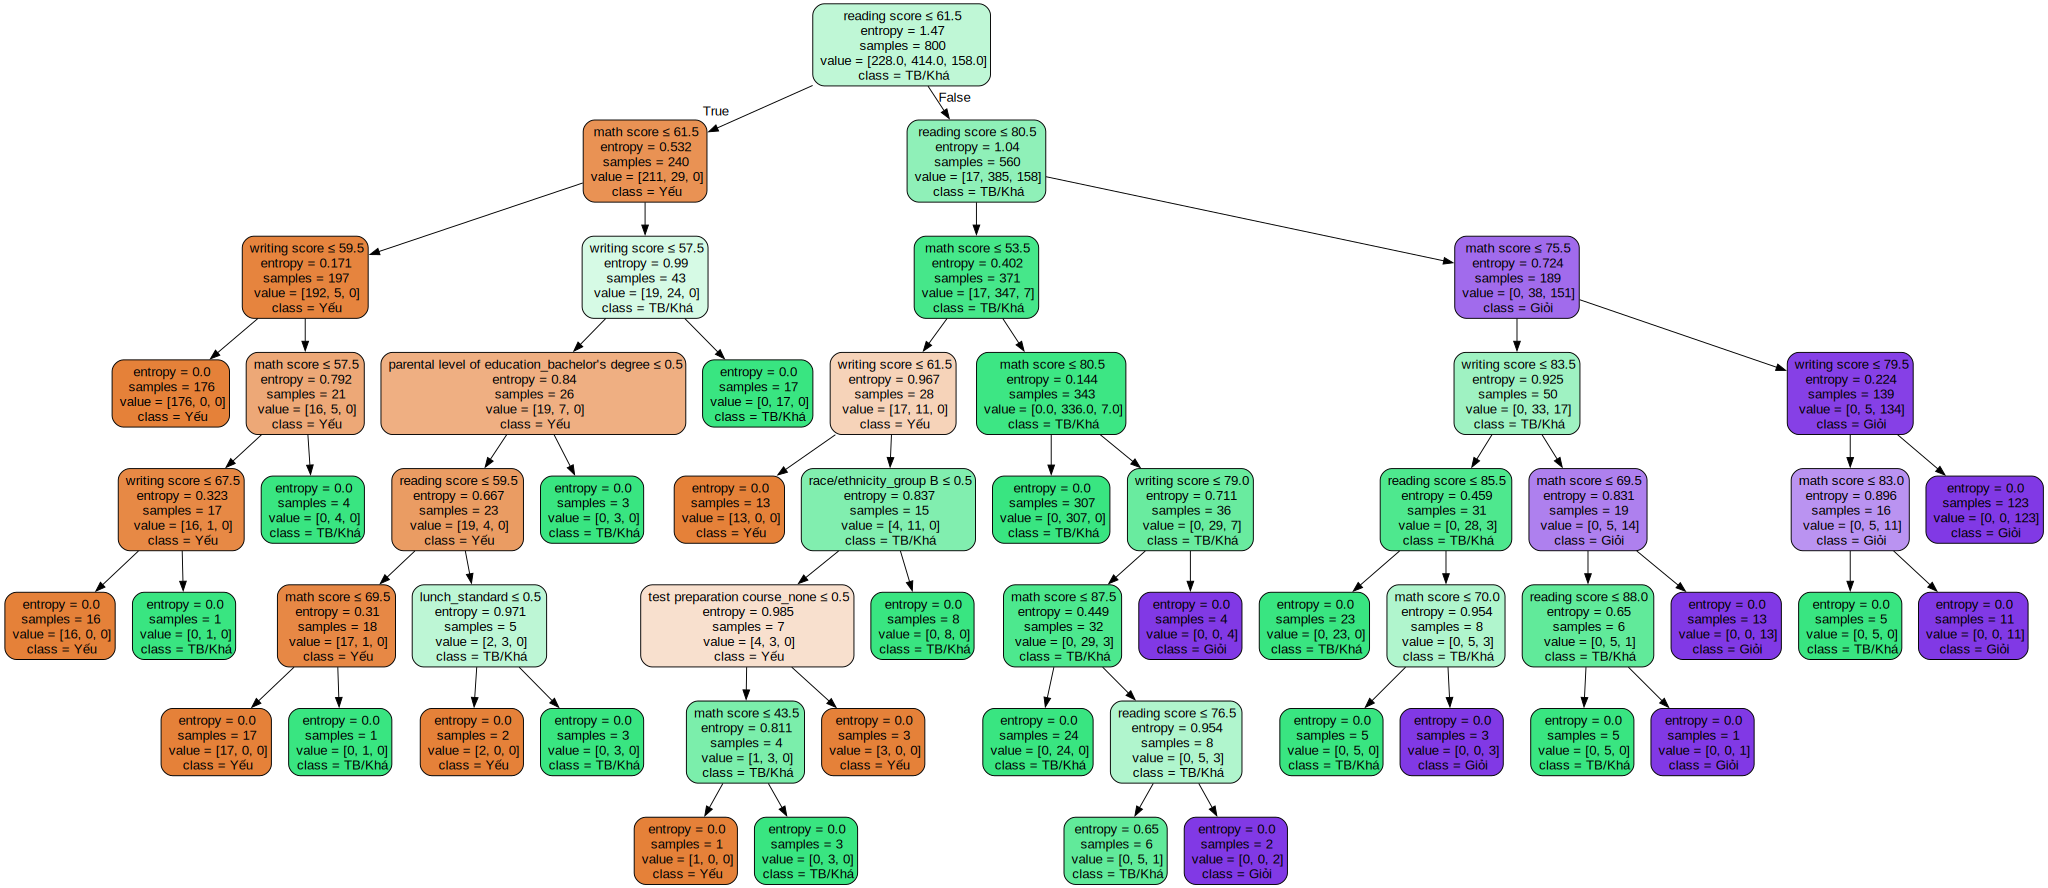

In [15]:
for depth, clf in models_by_depth.items():
    dot_data = export_graphviz(clf,
                                out_file=None,
                                feature_names=X_train.columns,
                                class_names=["Yếu", "TB/Khá", "Giỏi"],
                                filled=True, rounded=True,
                                special_characters=True)
    graph = graphviz.Source(dot_data)
    label = "None" if depth is None else depth
    print(f"\nCây quyết định (max_depth = {label})")
    display(graph)

## 3. Ghi lại accuracy  


Bảng thống kê accuracy theo từng độ sâu:


max_depth,None,2,3,4,5,6,7
accuracy,0.94,0.875,0.93,0.935,0.955,0.935,0.94


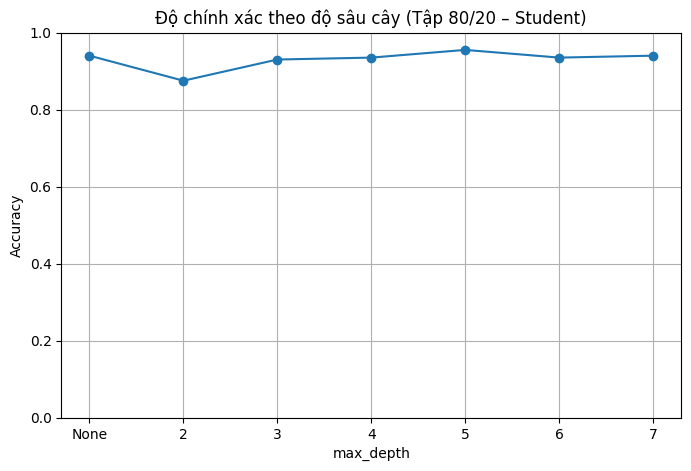

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Tạo bảng
df_acc = pd.DataFrame(accuracy_results, columns=["max_depth", "accuracy"])
df_acc["max_depth"] = df_acc["max_depth"].apply(lambda x: "None" if pd.isna(x) else int(x))
df_row = df_acc.set_index("max_depth").T

print("\nBảng thống kê accuracy theo từng độ sâu:")
display(df_row)

# Vẽ biểu đồ
depth_labels = [str(d) if d is not None else "None" for d, _ in accuracy_results]
acc_values = [acc for _, acc in accuracy_results]

plt.figure(figsize=(8, 5))
plt.plot(depth_labels, acc_values, marker='o')
plt.title("Độ chính xác theo độ sâu cây (Tập 80/20 – Student)")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()
